In [100]:
# libraries 

import sys
sys.path.insert(0, '..')
import pickle


# data stuff
import pandas as pd
import numpy as np

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# preproc
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from PythonScripts.plotting import plotting



# stats
from scipy.stats import kurtosis, skew
from sklearn.utils import resample
import scipy


# evaluation
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV




# modelling
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from PythonScripts.nn import cross_validate, plot_histories

from time import time







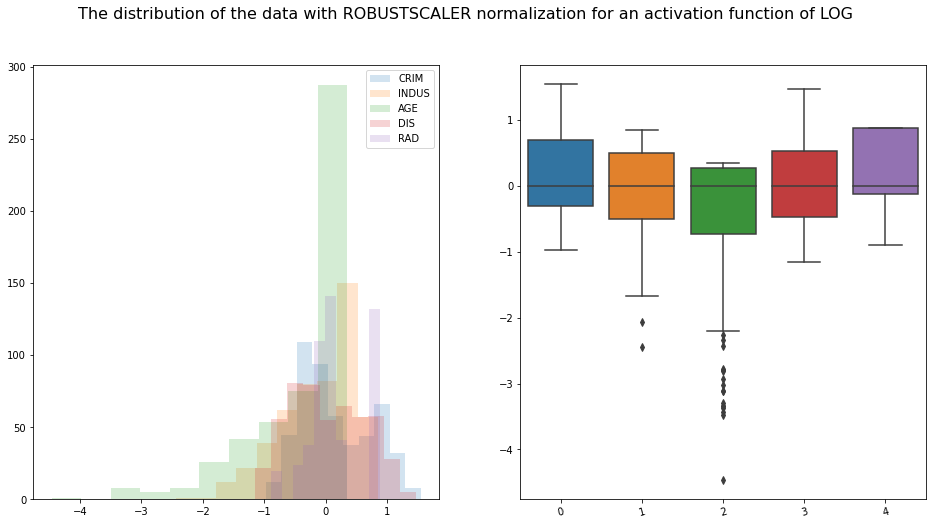

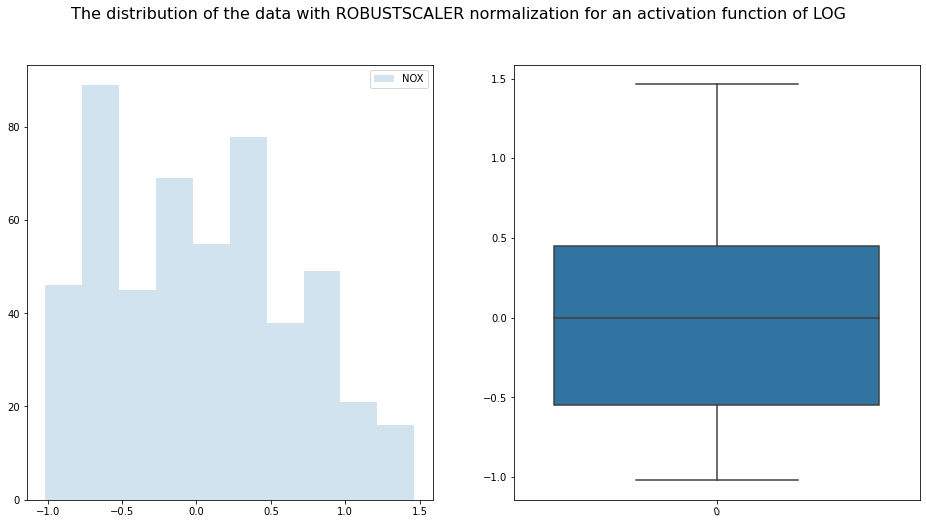

/Users/yousefnami/opt/anaconda3/envs/ai_hack_2021/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/yousefnami/opt/anaconda3/envs/ai_hack_2021/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/yousefnami/opt/anaconda3/envs/ai_hack_2021/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/yousefnami/opt/anaconda3/envs/ai_hack_2021/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConv

[array([0.86193118, 0.16683487, 0.05033681]),
 array([0.81205242, 0.20302274, 0.0696227 ]),
 array([0.81067407, 0.20247955, 0.06960949]),
 array([-0.01428685,  0.51407911,  0.37566818])]

In [177]:
### other functions
    
def log(x, inverse = False):
    return np.log(x) if not inverse else np.exp(x)


def from_regression(y_test, y_hat, num_attr):
    
    y_test = np.asarray(y_test)
    
    my_regression = {
        'residuals': y_test-y_hat,
        'r2': r2_score(y_test, y_hat),
        'r2_adj': 1 - (1-r2_score(y_test, y_hat))*(len(y_test)-1)/(len(y_test)-num_attr-1)
    }

    return my_regression

### models

def svr_model(**kwargs):
    model = SVR()
    return model

def lr_model(**kwargs):
    model = LinearRegression()
    return model

def ridge_model(**kwargs):
    model = Ridge()
    return model

def lasso_model(**kwargs):
    model = Lasso()
    return model



models = [svr_model, lr_model, ridge_model, lasso_model]
evaluation = [r2_score, mae, mse]
### data preparation

def prepare_data(remove_outliers = True):
    X_cols = ['CMEDV', 'CRIM', 'INDUS', 'AGE', 'DIS', 'LSTAT', 'RAD']
    X_cols.remove('CMEDV')
    X_cols.remove('LSTAT')


    #X_cols.remove('CRIM')


    y_col = ['NOX']
    
    path = '../data/Boston_Housing_Market_Challenge/boston_clusters.csv'
    df = pd.read_csv(path, index_col = 0)
    if remove_outliers:
        for col in X_cols:
            
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1    #IQR is interquartile range
            df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 *IQR)]
    X = df[X_cols]
    y = df[y_col]

    return X, y
    
    
def scale_data(X, y):
    X, kurts, skews = plotting(X, activation = log , normalization = RobustScaler)
    y, kurts, skews = plotting(y, activation = log , normalization = RobustScaler)

    X = np.asarray(X)
    y = np.asarray(y)
    return X, y


def main():
    
    # get data
    X, y = prepare_data(False)
    
    
    # scale data
    X, y = scale_data(X, y)
    

    
    # K = 5 folds, i.e. 80-20
    K = 5

    
    # base initial analysis on simple metrics (accuracy, MAE, MSE)
    metrics = []
    for model in models:
        local_metrics = []
        for train, test in KFold(n_splits=K, shuffle=True).split(X,y):

            my_model = model()
            my_model.fit(X[train], y[train])
            y_hat = my_model.predict(X[test])
            local_metrics.append(
                [metric(y[test], y_hat) for metric in evaluation]
            )
                
        metrics.append(
            np.asarray(local_metrics).mean(axis = 0)
        )
    
    
    #scores, histories = cross_validate(X, y, K = 5, 
    #                               epochs = 250,
    #                               # set to 1000 for good performance on YOUR model
    #                               verbose = 0,
    #                               batch_size = 128, # best when set to 50, 128 does not work bad either? So does 156! Early stopping will probably really help you model !
    #                               # set to 128 for your model
    #                               shuffle = True)
    #                               # = [early_stopping])
    #print(scores)
    #plot_histories(histories)

                
    return metrics 
main()

best model appears to be SVM, but not as explainable as Ridge or Linear Regression. Therefore to analyse both SVR and Ridge Regression.

In [222]:
# verify?
# best model
model = SVR(kernel = 'rbf', epsilon = 0.1, degree = 1, C = 12)

K = 5

    
    # base initial analysis on simple metrics (accuracy, MAE, MSE)
metrics = []

for train, test in KFold(n_splits=K, shuffle=True).split(X,y):

    model.fit(X[train], y[train])
    y_hat = model.predict(X[test])
    metrics.append(
        [metric(y[test], y_hat) for metric in evaluation] + [from_regression(y[test], y_hat, X[test].shape[1])['r2_adj']]
    )


model.fit(X,y)
summary =    np.asarray(metrics).mean(axis = 0)

pickle.dump(model, open('../data/models/SVR.pkl', 'wb'))
print(summary)

(102, 102)
(102, 101)
(102, 101)
(102, 101)
(102, 101)
[0.88486856 0.15301505 0.04298042 0.87882214]


/Users/yousefnami/opt/anaconda3/envs/ai_hack_2021/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/yousefnami/opt/anaconda3/envs/ai_hack_2021/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/yousefnami/opt/anaconda3/envs/ai_hack_2021/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/yousefnami/opt/anaconda3/envs/ai_hack_2021/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConv

In [180]:
model = LinearRegression()

K = 5

    
    # base initial analysis on simple metrics (accuracy, MAE, MSE)
metrics = []

for train, test in KFold(n_splits=K, shuffle=True).split(X,y):

    model.fit(X[train], y[train])
    y_hat = model.predict(X[test])
    metrics.append(
        [metric(y[test], y_hat) for metric in evaluation] + [from_regression(y[test], y_hat, X[test].shape[1])['r2_adj']]
    )

model.fit(X,y)


summary =    np.asarray(metrics).mean(axis = 0)
pickle.dump(model, open('../data/models/LR.pkl', 'wb'))


print(summary)

[0.81073176 0.20317613 0.06943086 0.80078953]


In [181]:
model = Ridge(alpha = 0.001)

K = 5

    
    # base initial analysis on simple metrics (accuracy, MAE, MSE)
metrics = []

for train, test in KFold(n_splits=K, shuffle=True).split(X,y):

    model.fit(X[train], y[train])
    y_hat = model.predict(X[test])
    metrics.append(
        [metric(y[test], y_hat) for metric in evaluation] + [from_regression(y[test], y_hat, X[test].shape[1])['r2_adj']]

    )
    
model.fit(X,y)
pickle.dump(model, open('../data/models/Ridge.pkl', 'wb'))


summary =    np.asarray(metrics).mean(axis = 0)
print(summary)

[0.81173232 0.20334999 0.06980802 0.80184397]


In [219]:
models = [
    SVR(kernel = 'rbf', epsilon = 0.1, C = 12),
    Ridge(alpha = 0.001), 
    LinearRegression()
]

/Users/yousefnami/opt/anaconda3/envs/ai_hack_2021/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


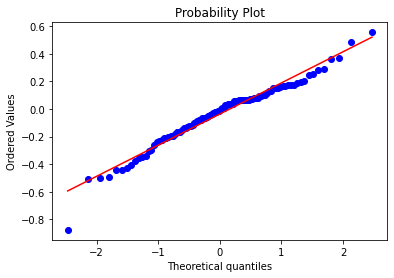

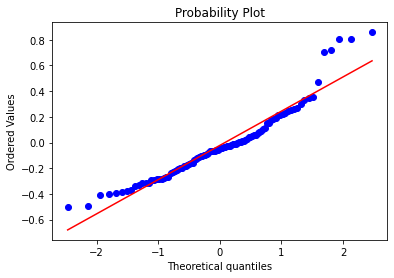

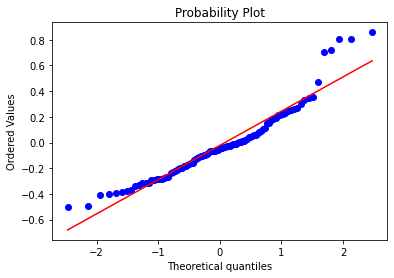

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
for model in models:
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test).reshape(102,1)
    scipy.stats.probplot([y_t[0] - y_h[0] for y_t, y_h in zip(y_test, y_hat)], plot = plt)
    plt.show()


    #print(model,y_hat)
    #resid = np.asarray([item[0] for item in y_test]) - model.predict(X_test)
    
    

Ridge regression and linear regression very similar. Since the SVR is substantially more 